# Auralizacaja - Symulacje odpowiedzi impulsowych
## 1. Wstęp

Celem dzisiejszych zajęć będzie zapoznanie się z różnymi metodami generowania odpowiedzi impulsowych pomeiszczeń na potrzeby auralizacji. Podstawą zajęć jest kod przygotowany w języku programowania Python. 

## 2. Ray Tracing
Podstawą dzisiejszych zajęć będzie algorytm wykorzystujący metodę promieniową do modelowania akustyki pomieszczenia. Cały algorytm podzielony jest na bloki, które wykonują różne akcje. Poszczególne bloki są opisane, aby ułatwić zrozumienie działania algorytmu.

Pierwszy blok kodu odpoiwada za importy wykorzystywanywch przez program bibliotek. Najważniejszą z punktu widzenia dzisiejszych zajęć jest biblioteka numpy. Zapewnia ona obsługę macierzy w sposób zbliżony do pakietu Matlab. Dokładne informacje o odpowiednikach komend i instukcji z języka Matlab dostępne są na stronie: https://docs.scipy.org/doc/numpy-1.15.0/user/numpy-for-matlab-users.html.

In [15]:
%matplotlib ipympl

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, widgets, IntProgress
#from IPython import display
import qgrid
import pandas as pd
import pickle
import cython

Następnie importowana jest biblioteka SimulationRT napisana na potrzeby dzisiejszych zajęć. Zawiera ona prosty algorytm śledzenia promieni. Pliki związane z tą biblioteką znajdują się w folderze simpleRT.

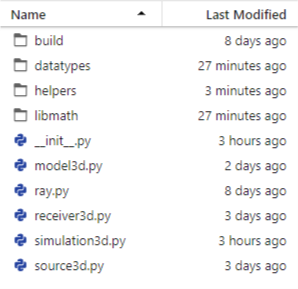

Po wczytaniu biblioteki tworzony jest podstawowy obiekt który będzie zawierał informacje o prowadzonych symulacjach - SimulationRT(). Obiekt ten przechowuje informacje o modelu, odbiornikach i nadajnikach oraz zawiera funkcie odpowiedzialne za wykonywanie obliczeń.

In [16]:
from simpleRT import SimulationRT
simulation = SimulationRT()

Następnie konieczne jest wczytanie modelu, dla którego będą przeprowadzane obliczenia. Modele są importowane z popularnego formatu obj. Format ten przypomina sposób opisu geometrii w programie CATT-Acoustic. Na początku pliku znajdują się informacje o wierzchołkach modelu, następnie definicje normalnych powierzchni i na końcu powierzchnie utworzone z wierzchołków.

Po wczytaniu model jest przypisywany do symulacji.

In [17]:
from simpleRT import Model3D
import os

folder = 'modele'
basename = 'korytarz'
filename = basename+'.obj'
model3D = Model3D()

os.chdir(folder)
model3D.loadOBJ(filename)
os.chdir('..')

simulation.model3d = model3D

Kolejne bloki kodu odpowiadają za wyświetlenie modelu sali i zadanie niektórych parametrów. Ich szczegółowa analiza nie jest konieczna, ponieważ odpowiadają one tylko za interakcję z użytkownikiem. Jeżeli jesteś ciekaw jak działają, aby wyświetlić ukryty kod kliknij na niebieski pasek obok trzech kropek.

Prawy przycisk myszy przesuwa model, lewy przycisk obraca model, kółko przybliża i oddala.

UWAGA! W celu zatwierdzenia wprowadzanych wartości konieczne jest wciśnięcie klawisza enter!

In [18]:
model_display_holder = widgets.Output(layout={'border': '1px solid black'})
model_display_holder

Output(layout=Layout(border='1px solid black'))

In [19]:
from notebook_helpers.helpers import *
display_model(model_display_holder, model3D, simulation)

In [20]:
### Create table with material absorption and diffusion coefficients, handle GUI interactions

freq_idx = {'125Hz':0, '250Hz':1, '500Hz':2, '1000Hz':3, '2000Hz':4, '4000Hz':5}
from simpleRT.helpers import matloader as mat

def on_rt_edited(event, widget):
    df = widget.get_changed_df() 
    if event['column'] == "Diffusion":
        model3D.materials[event['index']]['diffusion_coeff'] = event['new']
    else:        
        model3D.materials[event['index']]['absorption_coeff'][freq_idx[event['column']]] = event['new']
    filename = os.path.join(folder,basename+'.mat')
    mat.save_materials(model3D, filename)
    return True
    
try:
    filename = os.path.join(folder,basename+'.mat')
    model3D = mat.load_previous_materials(model3D, filename)
except:
    print('Material file not found: %s' % s)
    pass
    
df = pd.DataFrame([np.append(mat['absorption_coeff'],mat['diffusion_coeff']) for name, mat in model3D.materials.items()], columns = ['125Hz', '250Hz', '500Hz', '1000Hz', '2000Hz', '4000Hz', 'Diffusion'], index = model3D.materials.keys())
#qgrid_widget = qgrid.show_grid(df)
#qgrid_widget.on('cell_edited', on_rt_edited)
#qgrid_widget

In [21]:
#### Create source, assign it to model, handle interactions with GUI
from simpleRT import Source3D
source = Source3D()
simulation.source = source

spos = source.position

print('Pozycja źródła dźwięku:')
@interact(x=(-50,50,0.01),y=(-50,50,0.01),z=(0,50,0.01))
def set_source_position(x,y,z=1.5):
    spos.fromArray([x,z,-y]) 
    display_model(model_display_holder, model3D, simulation)

##### Create receiver, assign it to model, handle interactions with GUI
from simpleRT import Receiver3D
receiver = Receiver3D()
simulation.receiver = receiver

print('Pozycja odbiornika:')
rpos = receiver.position
@interact(x=(-50,50,0.01),y=(-50,50,0.01),z=(0,20,0.01))
def set_receiver_position(x,y,z=1.2):
    rpos.fromArray([x,z,-y])
    display_model(model_display_holder, model3D, simulation)

print('Promień odbiorników:')
@interact(radius=(0,1,0.01))
def set_receiver_rad(radius = simulation.receiver.radius):
    simulation.receiver.radius = radius

Pozycja źródła dźwięku:


interactive(children=(FloatSlider(value=0.0, description='x', max=50.0, min=-50.0, step=0.01), FloatSlider(val…

Pozycja odbiornika:


interactive(children=(FloatSlider(value=0.0, description='x', max=50.0, min=-50.0, step=0.01), FloatSlider(val…

Promień odbiorników:


interactive(children=(FloatSlider(value=0.20000000298023224, description='radius', max=1.0, step=0.01), Output…

Ustal pozycje źródła i nadajnika zwryfikuj przyjęte wszpółczynniki pochłaniania i rozproszenia dźwięku. Po zadaniu parametrów modelu można przejść do wykonywania obliczeń. W poniższym bloku wykonywane są symulacje. Na początek uruchom symulacje z domyślnymi parametrami. 

Parametry:
 1. no_rays - liczba promieni
 2. fs - fs
 3. sim_length - dlugość symulacji
 4. max_reflection_order - określa liczbę odbić po której promień jest odrzucany,
 5. brute_force - zmienia sposób przeszukiwania geometrii, jeżeli wartość jest ustawiona na false wykorzystywane jest drzewo BVH do szybszego wykrywania przecięć (więcej informacji na wykładzie 29.11.2018), 
 6. reflection_model - zmienia sposób modelowania odbicia dźwięku, dostępne opcje `ReflectionModel.Phong` i `ReflectionModel.Base` (więcej informacji na wykładach 22/29.11.2018)
 7. intersection_model - zmienia sposób wykrywania przecięć promieni z modelem `RaySphereIntersection.Full` i `RaySphereIntersection.Simple`. W przypadku modelu Full uwzględniany jest czas propagacji promienia przez odbiornik, w przypadku modelu Simple uwzględniany jest tylko czas dotarcia do środka odbiornika (więcej informacji na wykładach 29.11.2018).

W czasie trwania obliczeń zapoznaj się z opisem działania algorytmu znajdującym się poniżej.

In [22]:
from simpleRT import ReflectionModel, RaySphereIntersection

no_rays = 10000
fs = 44100
sim_length = 2
max_reflection_order = 45
brute_force = False
reflection_model = ReflectionModel.Phong
intersection_model = RaySphereIntersection.Full

# Define callback to display progress bar
global f
f = IntProgress(min=0, max=simulation.no_rays) # instantiate the bar
display(f) # display the bar
def callback(no_rays):
    global f
    f.value += 1

def run_simulations(sim):
    sim.initialize_simulation_parameters(no_rays, fs, sim_length, \
                                        max_reflection_order, brute_force, 
                                        reflection_model,intersection_model)
    sim.initialize_rays() #create array of rays, set ray energy and position in the source, generate random ray direction
    sim.run_simulation(callback)
        
    return sim

simulation = run_simulations(simulation)
print(simulation.no_lost)

IntProgress(value=0, max=0)

0


Główny algorytm programu można przedstawić w postaci pseudokodu jako:

---
```
Jeżeli liczba odbić jest mniejsza od maksymalnego rzędu odbicia:
    Sprawdź przecięcie promienia z odbiornikiem
    Wyszukaj z którą powierzchnią przecina się promień.
    Jeżeli promień nie przecina się z powierzchnią
        Uznaj promień za stracony
    Sprawdż czy przecięcie z odbiornikiem jest przed przecięciem z powierzchnią
        Jeżeli tak dodaj energię promienia do odbiornika
    Przesuń promień do punktu następnego odbicia
    Oblicz energię i kierunek promienia po odbiciu
```
---

Szczegółowo przedstawia się on w sposób następujący:

---
```cython 
last_face = None
for i in range(self.max_refl_ord):

    #Find colision with receiver 
    t1 = np.Inf
    rec_hit = libmath.ray_sphere_intersection(ray.position, ray.direction ,self.receiver.position, self.receiver.radius)
    if rec_hit is not -1:
        t1 = rec_hit[0] #entry point
        t2 = rec_hit[1] #out_point

    #Find colision with model geometry
    if self.brute_force:
        tmin, hit_face = self.brute_force_triangle_intersection(ray, self.model3d.faces, last_face)
    else:         
        tmin, hit_face = self.kd_tree_triang_intersection(ray, last_face)


    # Test if model hit any face, if not it is lost
    if hit_face is None:
        ray.ray_lost()
        self.no_lost+=1
        return

    # Test if colision with model is after colision with receiver
    if tmin>t1 and t1>0:              
        entry_sample = int(min((ray.total_dist + t1)/self.dv, self.fs*self.sim_len))
        exit_sample = int(min((ray.total_dist + t2)/self.dv + 1, self.fs*self.sim_len))
        ds = exit_sample-entry_sample

        # If simlified intersection model is selected - using only meadle intersection sample
        if self.ray_sphere_int == RaySphereIntersection.Simple:
            entry_sample = int((exit_sample-entry_sample)/2)
            exit_sample = entry_sample+1
            ds=1

        # add energy to result
        self.result[:,entry_sample:exit_sample] += np.transpose(np.tile(ray.energy,(ds,1)))
        ray.receiver_hit = True

    # Move ray to face hit position, update energy
    dif_coeff = self.model3d.materials[hit_face.mat_name]['diffusion_coeff']
    abs_coeff = self.model3d.materials[hit_face.mat_name]['absorption_coeff']
    last_face = hit_face
    ray.position = libmath.move_ray(ray.position, ray.direction, tmin)
    ray.total_dist += tmin
    ray.energy*=(1-abs_coeff)

    # calculate reflection based on chosen reflection model
    if self.reflection_model == ReflectionModel.Base:
        ray.direction = libmath.base_reflection(ray.direction, self.model3d.normals[hit_face.normal_idx], dif_coeff)
    elif self.reflection_model == ReflectionModel.Phong:
        ray.direction = libmath.phong_reflection(ray.direction, self.model3d.normals[hit_face.normal_idx], dif_coeff)
    ray.refl_order+=1
```
---

W przypadku kiedy odbiornik ma określoną objętość (`intersection_model = RaySphereIntersection.Full`, konieczne jest podzielenie wyniku symulacji przez objętość odbiornika. W ten sposób wyniki są niezależne od objętości odbiornika.

In [23]:
receiver_volume = (4/3*np.pi*simulation.receiver.radius**3)
simulation.result = simulation.result/receiver_volume

Nastęnie możemy wyświetlić wyniki symulacji. Zmienna simulation.results zawiera echogramy dla poszczególnych częstotliwości. Wynik dla określonej częstotliwości można otrzymać przez `simulations.result[idx]`, gdzie `idx`to index częstotliwości. Pierwszy wykres przedstawia zarejestrowaną energię docierającą do odbiornika (kwadrat ciśnienia akustycznego), drugi przedstawia echogram w skali logarytmicznej.

In [24]:
e_tot = np.sum(simulation.result, axis=0)

plt.figure(1)
plt.plot(simulation.time,e_tot)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [25]:
plt.figure(2)
zeros = np.zeros(len(e_tot))
Lp = 10*np.log10(e_tot/10e-12)
Lp[Lp==-np.inf]=0
plt.plot(simulation.time,Lp)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Na koniec możemy zapisać wyniki. Wynik symulacji zapisywany jest do pliku, którego nazwa składa się z nazwy modelu, liczby promieni w symulacjach oraz rozszerzenia ".res".

In [13]:
pickle.dump( simulation, open( os.path.join(folder,basename+str(no_rays)+".res"), "wb" ) )

## 3. Auralizacjia

Pierwszym krokiem jest wczytanie wyników symulacji. Jeżeli w danej sesji symulajce zostały przeprowadzone wybierany jest wynik przechowywany w pamięci, jeżeli nie możliwe jest wczytanie wyników o zadanych parametrach. Konieczne może być też ponowne zaimportowanie wykorzystywanych bibliotek.

In [13]:
%matplotlib ipympl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import cython
import os

In [26]:
import pickle

#del simulation

if 'simulation' not in locals():
    no_rays = 150000
    basename = 'korytarz'
    simulation = pickle.load( open( os.path.join(folder,basename+str(no_rays)+".res"), "rb" ) )
    fs=44100

Następnie na podstawie echogramów chcemy uzyskać odpowiedzi impulsowe. Ponieważ nasze echogramy są próbkowane z częstotliwością 44100Hz, przejście promienia przez odbiornik trwa więcej niż jedną próbkę. Na potwierdzenie powiększ prążek odpowiadający za dźwięk bezpośredni na wykresach powyżej. Zauważ, że energia jest rozłożona na wiele próbek. Dla poprawnej auralizacji konieczne jest założenie, że odbiornik jest punktem, a poszczególne promienie docierają do niego tylko w pojedynczych, określonych chwilach czasu.

Przeprowadź ponowne obliczenia dla odbiornika o promieniu 1cm, porównaj wyniki z otrzymanymi w poprzedniej symulacji. Nie zapisuj wyników!

Ok, jak widać znaczniej mniej promieni trafiło do odbiornika i wyniki są wyraźnie mocniej zaszumione. W celu zwększenia dokładności możliwe jest zwiększenie liczby promieni, ale to wiąże się z dłuższym czasem obliczen. Zamiast tego można sprowadzić wyniki do punktu przez wykrywanie maksimów.

### Zadanie 1
Zapoznaj się z opisem funkcji find_peaks z biblioteki scipy.signal i uzupełnij funkcję `peak_detection(result)`, tak aby przyjmując wektor z echogramem pozostawiała tylko występujące w nim maksima lokalne, a pozostałe próbki zerowała. Jeżeli funkcja jest zaimplelentowana poprawnie po wykonaniu bloku powinna pojawić się wartość `TRUE`.

In [27]:
from scipy.signal import find_peaks
import numpy as np

#def peak_detection(result):
#    # Your code goes here
#    
#    return pf_res

from aura.helpers import peak_detection as pd_ref

peak_detection = pd_ref

#reference = pd_ref(simulation.result[0])
#test = peak_detection(simulation.result[0])

#print(np.array_equal(reference, test))

Mając echogramy po wykrywaniu impulsów koniecznie jest uwzględnienie jakiego pasma częstotliwości one dotyczą. Wtym celu konieczna jest filtracja echogramu z wkorzystaniem filtrów oktawowych.

In [28]:
from scipy.signal import find_peaks
from pyfilterbank import FractionalOctaveFilterbank

#Initialize octave filter bank
ofb = FractionalOctaveFilterbank(fs, order=4,nth_oct=1,  start_band=-3, end_band=2)
print(ofb.center_frequencies)

def filter_octave(data, ofb, idx):
    y, states = ofb.filter(data**(1/2))
    return y[:,idx]


[ 125.  250.  500. 1000. 2000. 4000.]


Teraz pozostaje tylko przefiltrować echogramy dla każdej częstotliwości i je ze sobą zsumować, żeby otrzymać modelowaną odpowiedź impulsową.

In [29]:
%matplotlib ipympl
import matplotlib.pyplot as plt

do_peak_detection = True

#Variable creation
pf_filter = np.empty(simulation.result.T.shape, dtype=float)
peak_det = np.empty(simulation.result.T.shape, dtype=float)

#For each freq range detect peaks anf filter the echogram
for idx in range(len(simulation.result)):
    if do_peak_detection:
        peak_det[:,idx] = peak_detection(simulation.result[idx])
        pf_filter[:,idx] = filter_octave(peak_det[:,idx], ofb, idx)
    else:
        pf_filter[:,idx] = filter_octave(simulation.result[idx], ofb, idx)

ir = np.sum(pf_filter,axis=1)

plt.figure(4)
plt.plot(simulation.time,ir)

plt.figure(5)
zeros = np.zeros(len(simulation.result[0]))
Lp = 10*np.log10(ir**2/(2e-5)**2)
Lp[Lp==-np.inf]=0
plt.plot(simulation.time,Lp)
plt.ylim(np.max(Lp)-70,np.max(Lp)+5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(0.543350584716265, 75.54335058471626)

Następnie można dokonać splotu sygnału z otrzymaną odpowiedzią impulsową.
Funkcja fftconvolve wykonuje szybki splot z wykorzytaniem transformacji Fouriera.

In [30]:
import soundfile as sf
from scipy.signal import fftconvolve

#Load audio sample and convolve
audio_folder = 'audio'
audio_file = 'muzyka2.wav'
data, samplerate = sf.read(os.path.join(audio_folder,audio_file))
convolved = fftconvolve(data[:,1], ir)

Wynik jest normalizowany i przesyłany do odtwarzacza

In [33]:
#import sounddevice as sd
import IPython.display as ipd

convolved = convolved/np.max(convolved)
#sd.play(convolved, fs)
ipd.Audio(convolved, rate=fs)

## 4. Zadania
 ### Zadanie 2
    Porównaj wyniki auralizacji dla Korytarza z wynikiem splotu ze zmierzoną odpowiedzią impulsową (2gie zajęcia) i rzeczywistym nagraniem z tego pomieszczenia.
    
 ### Zadanie 3
    Jaki wpłw na wynik auralizacji ma wykrywanie maksimów,
    
 ### Zadanie 4
    Sprawdź jak zmieniają się wyniki auralizacji w zaleźności od liczby promieni i liczby odbić w symulacjach. (W folderze z plikami są już wyniki dla dużych liczb promieni)
    
 ### Zadanie 5
    Zmodyfikuj funkcję generującą odpowiedź impulsową tak, aby wykonywać auralizację w zakresie częstotliwości od 32.5 do 16kHz. Przyjmij, że wyniki auralizacji dla pasm poza zakresem obliczeń są takie same jak dla pasm odpowiednio 125Hz i 4kHz. Czy słychać różnicę?
    
 ### Zadanie 6
     Zastanów się jak korzystając z powyższego programu wykonać auralizację stereofonicznego systemu nagłośnienia, czy możliwe jest uwzględnienie funkcji HRTF?